In [1]:
'''
Using a toy function that sort of represents the curving path of a financial instrument, let's apply
mathematical tools
'''

"\nUsing a toy function that sort of represents the curving path of a financial instrument, let's apply\nmathematical tools\n"

In [2]:
import numpy as np
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [3]:
def f(x):
    return np.sin(x) + 0.5 * x

In [12]:
def create_plot(x, y, styles, labels, axlabels):
    plt.figure(figsize=(20,12))
    for i in range(len(x)):
        plt.plot(x[i], y[i], styles[i], label=labels[i]) # Nice general plotting function
        plt.xlabel(axlabels[0])
        plt.ylabel(axlabels[1])
    plt.legend(loc=0) # do your best mpl!

In [13]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 50)

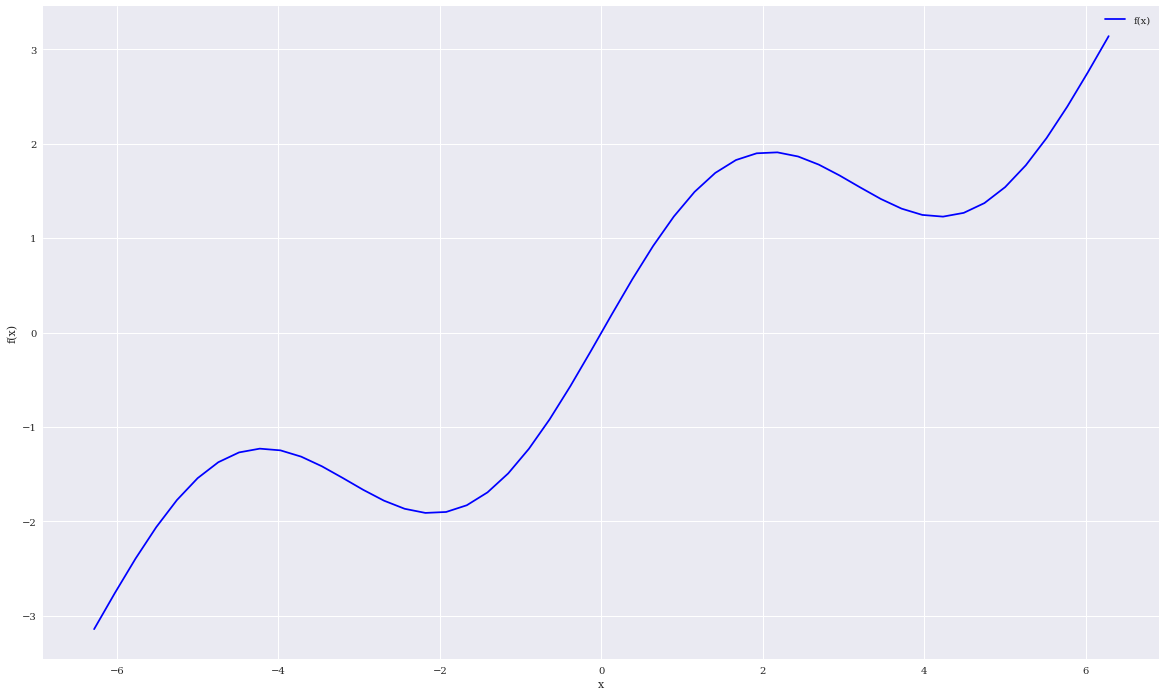

In [14]:
create_plot([x], [f(x)], ['b'], ['f(x)'], ['x', 'f(x)'])

In [17]:
'''
First up is regression
Linear regression finds the degree 1 polynomial (i.e. line) that minimize the squared errors
of the data points where x is the independent variable and y is the dependent variable

Output of Full is:
Regression parameters - highest degree first - in this case 1 (x), 0 (constant)
Residuals - squared sum of errors? check this!
Effective Rank
Singular Values - // TODO review SVD to give a good answer for this
Condition Number: The change in output y for a ∆x steptKPI
'''
res = np.polyfit(x, f(x), deg=1, full=True)
res # i.e. (4.288 * 10 ^ -1)x - (a very very very small number)

(array([ 4.28841952e-01, -1.31499950e-16]),
 array([21.03238686]),
 2,
 array([1., 1.]),
 1.1102230246251565e-14)

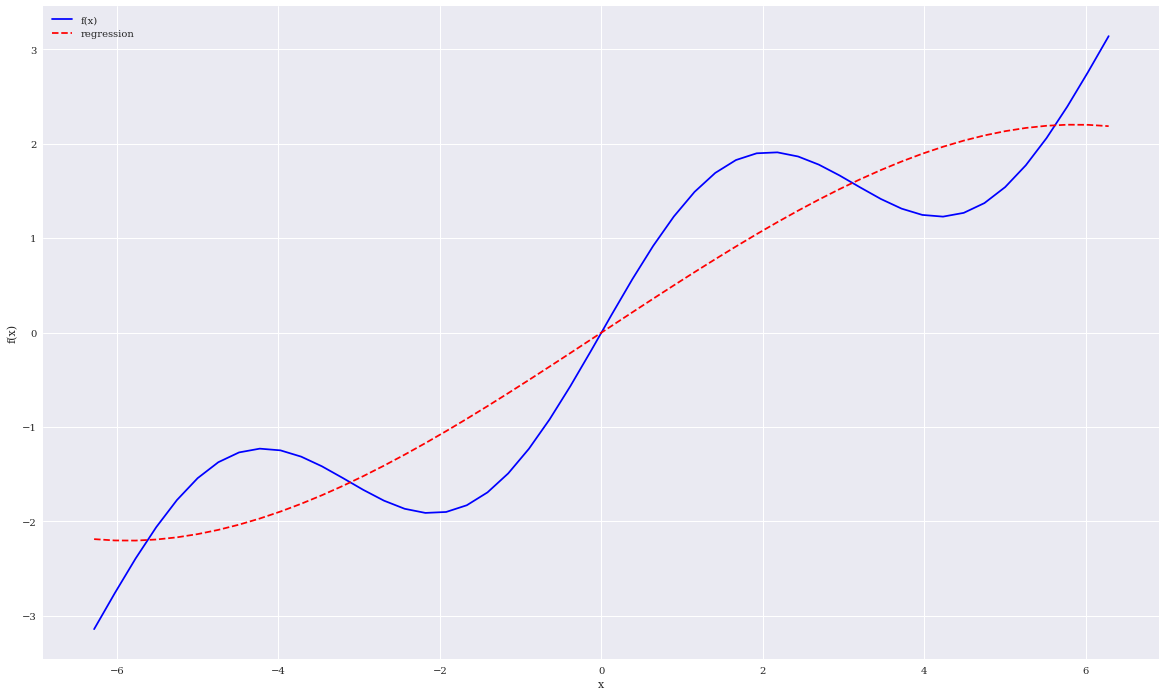

In [45]:
'''
That error number is very high - a higher degree polynomial can help us out
'''
reg = np.polyfit(x, f(x), deg=3)
ry = np.polyval(reg, x)
create_plot([x, x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [27]:
'''
What if we went really wild and did a 9th degree polynomial?
'''
reg = np.polyfit(x, f(x), deg=9)
ry = np.polyval(reg, x)
np.allclose(f(x), ry) # are all of the values of these arrays very close?

False

In [28]:
np.mean((f(x) - ry) ** 2) # very very small mean squared error, good!

2.0214795375384566e-05

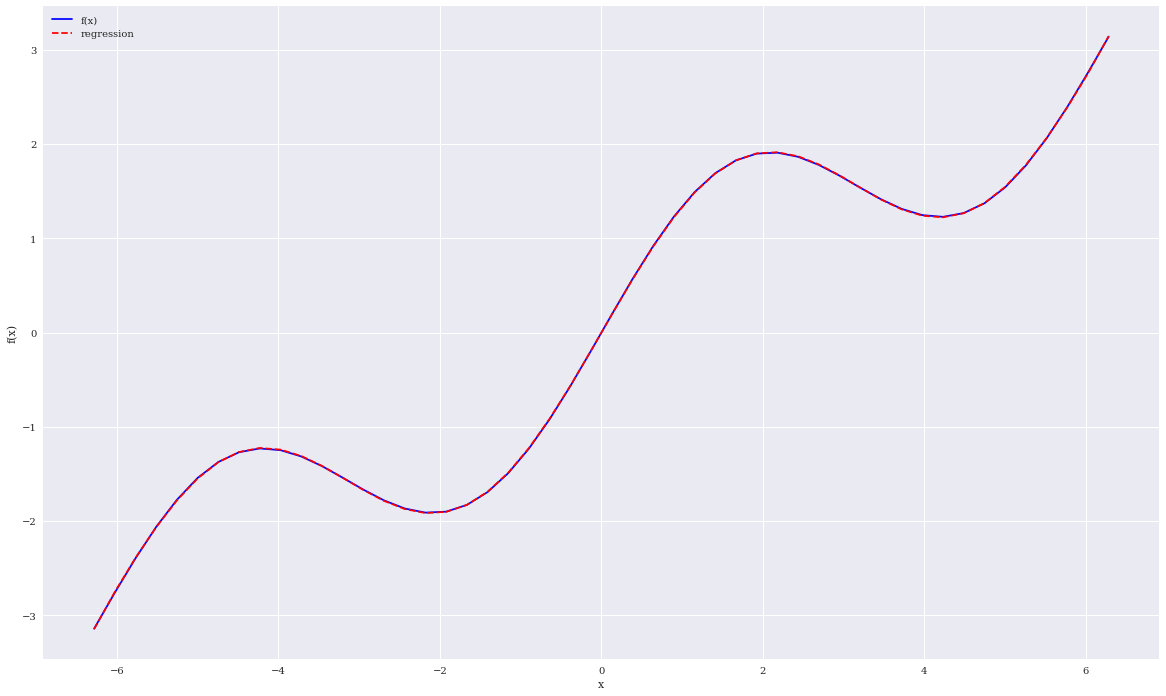

In [30]:
create_plot([x, x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)']) # Indistinguishable!

In [62]:
'''
For more control, you can also set the array of basis functions yourself - numpy.polyfit is actually calling
this method in the source code
'''
matrix = np.zeros((3 + 1, len(x))) # 3rd degree polynomial + a constant over length of x
matrix[3, :] = x ** 3
matrix[2, :] = x ** 2
matrix[1, :] = x
matrix[0, :] = 1

In [63]:
reg = np.linalg.lstsq(matrix.T, f(x), rcond=None)[0]

In [66]:
'''
# Note that a regression is just the dot product of a matrix of power coefficients and the regressor coefficients
'''
ry = np.dot(reg, matrix)

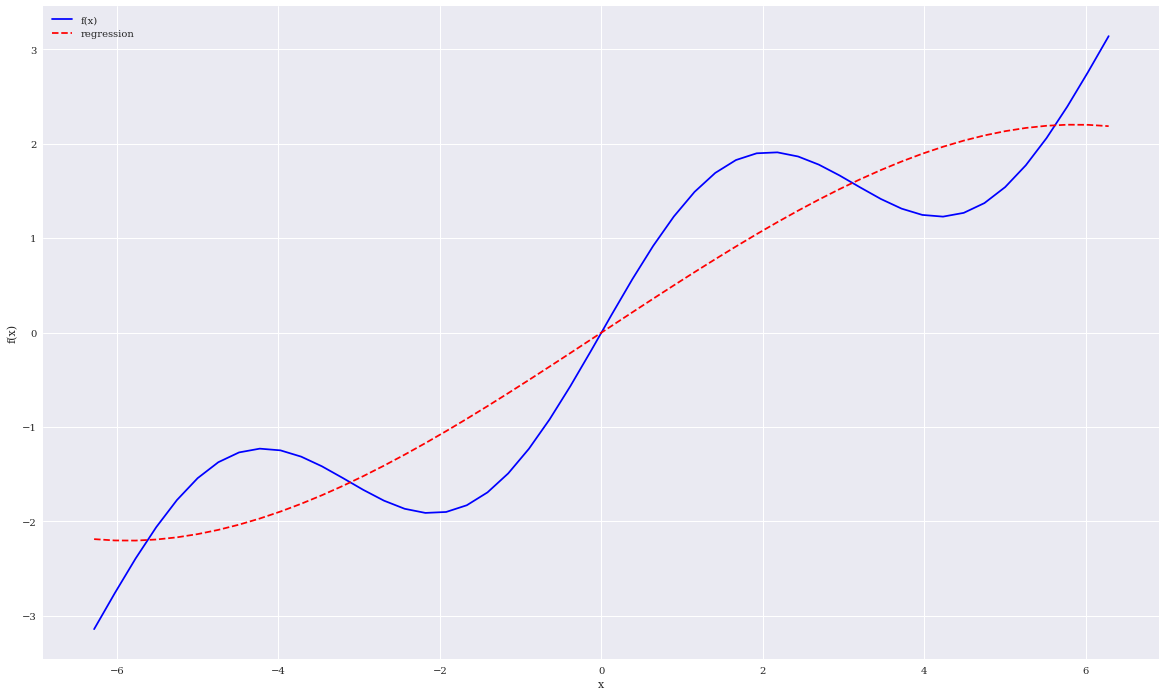

In [67]:
create_plot([x,x], [f(x), ry], ['b', 'r--'], ['f(x)', 'regression'], ['x', 'f(x)'])

In [68]:
matrix[3, :] = np.sin(x) # Replace cubic basis function with sin

In [71]:
reg = np.linalg.lstsq(matrix.T, f(x), rcond=None)[0]

In [73]:
ry = np.dot(reg, matrix)

In [74]:
np.allclose(f(x), ry) # Fit is perfect since we've added the characteristic function as a basis

True

In [ ]:
np.mean((f(x)))